# FLAN-T5-BASE CHATBOT MODEL

This model is used to provide textual answers to general questions.
For this project we used the conversations dataset: https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot

## Import all the necessary libraries

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
from datasets import DatasetDict
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel
import json

## Read the data

We checked the structure of the dataset and counted the number of available questions/answers. 

In [28]:
# Create a DataFrame
chatbot_df = pd.read_csv('Conversation.csv')
chatbot_df = chatbot_df.drop(columns = ['Unnamed: 0'])

In [29]:
# Show the first few rows of the DataFrame
chatbot_df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [30]:
chatbot_df.shape # print the dataset shape

(3725, 2)

## EDA

EDA was performed by following a similar procedure to the one described by Singh (n.d.).

References:
Singh, H. (n.d.). Complete Guide to EDA on Text Data. Kaggle. https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

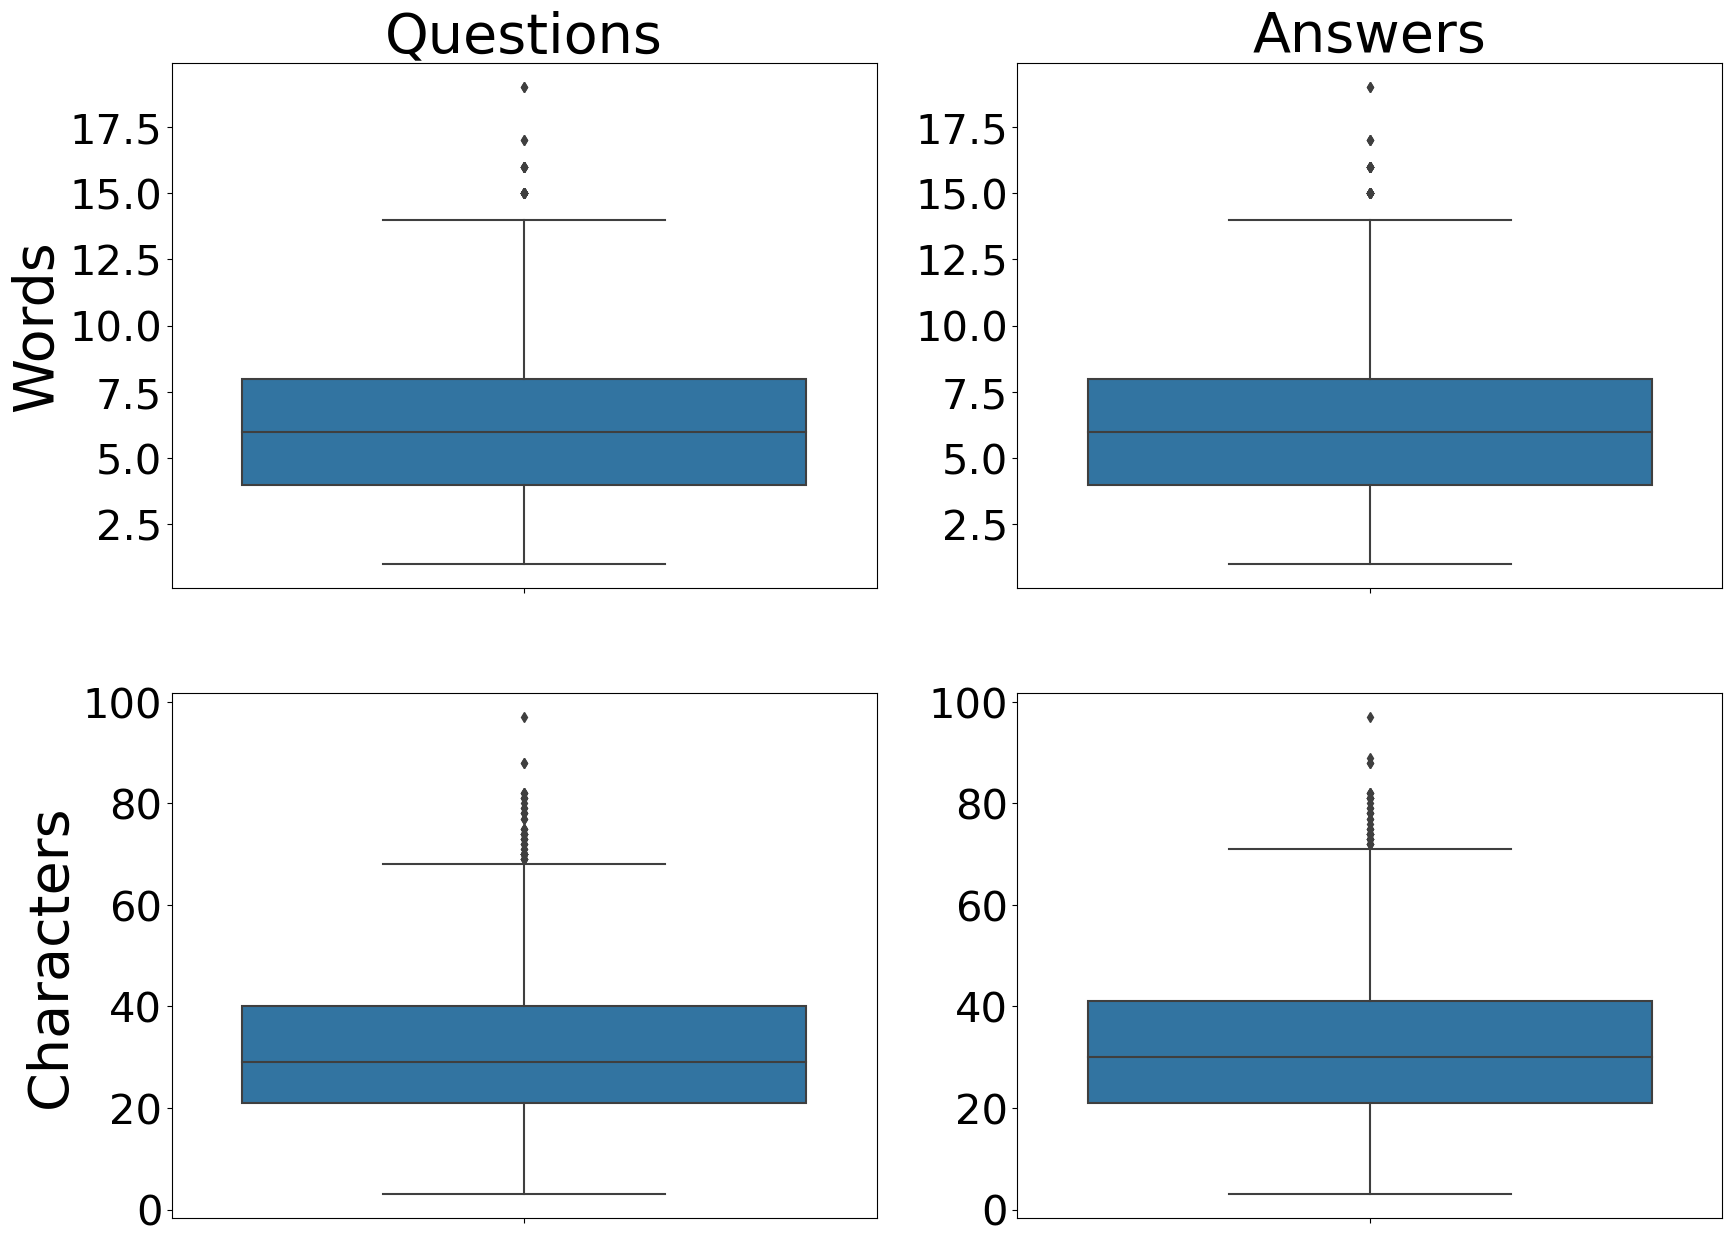

In [31]:
# Function to count the number of words in a sentence
def count_words(text):
    words = text.split() # extract the words from text
    num_words = len(words) # count the number of words
    return num_words

# Function to count the number of characters in a sentence
def count_characters(text):
    num_char = len(text) # count the number of chatacters
    return num_char

num_words_question = chatbot_df['question'].apply(count_words)
num_words_answer = chatbot_df['answer'].apply(count_words)
num_char_question = chatbot_df['question'].apply(count_characters)
num_char_answer = chatbot_df['answer'].apply(count_characters)

plt.figure(figsize = (20, 15))  
plt.subplot(2, 2, 1)
sns.boxplot(y = num_words_question)
plt.yticks(fontsize = 30)
plt.ylabel('Words', fontsize = 40)
plt.title('Questions', fontsize = 40)
plt.subplot(2, 2, 2)
sns.boxplot(y = num_words_answer)
plt.yticks(fontsize = 30)
plt.ylabel('')
plt.title('Answers', fontsize = 40)
plt.subplot(2, 2, 3)
sns.boxplot(y = num_char_question)
plt.yticks(fontsize = 30)
plt.ylabel('Characters', fontsize = 40)
plt.subplot(2, 2, 4)
sns.boxplot(y = num_char_answer)
plt.yticks(fontsize = 30)
plt.ylabel('')
plt.savefig('Boxplots_QA.png')
plt.show()

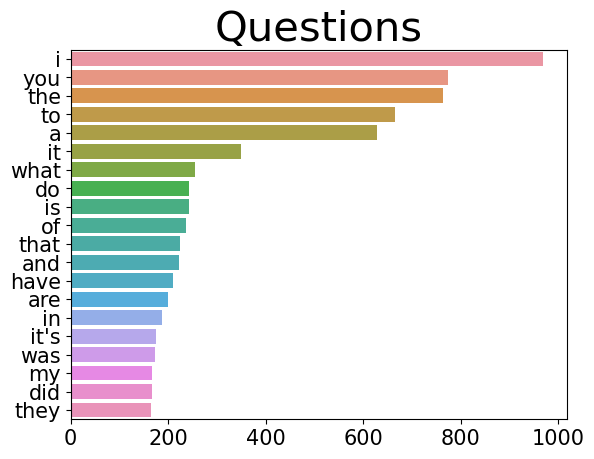

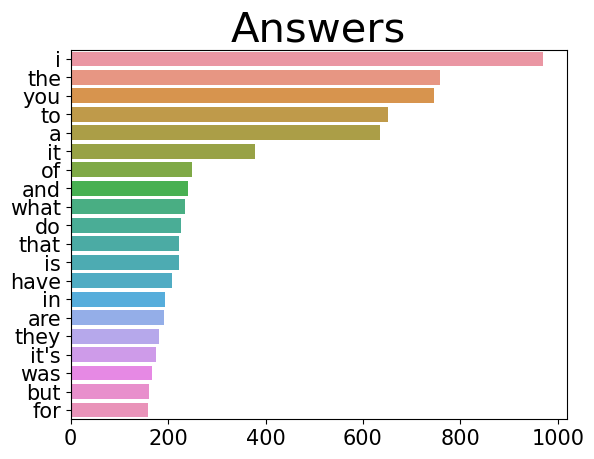

In [32]:
# Identify the most frequent words in the question/answer columns

# Function to get the list of words in a sentence
def list_words(text):
    words = text.split() # extract the words from text
    return words

# Function to get the top 20 most common words and their counts
def words_freq(corpus):
    mostcommon = Counter(corpus).most_common(20)
    words = []
    counts = []
    for word, count in mostcommon:
        words.append(word)
        counts.append(count)
    return words, counts

words_question = chatbot_df['question'].apply(list_words)
words_answer = chatbot_df['answer'].apply(list_words)
corpus_question = []
for jj in range(len(words_question)):
    corpus_question += words_question[jj] # all the words in all the questions
corpus_answer = []
for jj in range(len(words_answer)):
    corpus_answer += words_answer[jj] # all the words in all the answers
words_question, counts_question = words_freq(corpus_question) # top 20 most common words and their counts in questions
words_answer, counts_answer = words_freq(corpus_answer) # top 20 most common words and their counts in answers

sns.barplot(x = counts_question, y = words_question)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Questions', fontsize = 30)
plt.savefig('Common_Words_Questions.png')
plt.show()

sns.barplot(x = counts_answer, y = words_answer)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Answers', fontsize = 30)
plt.savefig('Common_Words_Answers.png')
plt.show()

## Preprocessing

In order to replace contractions, we adopted the same procedure described in Replace apostrophe/short words in python (n.d.). 

References: 
Replace apostrophe/short words in python. (n.d.). Stack Overflow. Retrieved July 24, 2024, from https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python

In [33]:
# List of common contractions 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

# Function to replace contractions, remove punctuation and apply lowercase
def clear_text(text):
    for word in text.split(): # remove contractions and apply lowercase
        word = word.lower()
        if word in contractions:
            text = text.replace(word, contractions[word])
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    return text

chatbot_df['question'] = chatbot_df['question'].apply(clear_text)
chatbot_df['answer'] = chatbot_df['answer'].apply(clear_text)
chatbot_df.head()

,question,answer
0,hi how are you doing,I am fine how about yourself
1,I am fine how about yourself,I am pretty good thanks for asking
2,I am pretty good thanks for asking,no problem so how have you been
3,no problem so how have you been,I have been great what about you
4,I have been great what about you,I have been good I am in school right now


In [8]:
# Tokenization
chatbot_df['token_question'] = chatbot_df['question'].apply(nltk.word_tokenize)
chatbot_df['token_answer'] = chatbot_df['answer'].apply(nltk.word_tokenize)
chatbot_df.head()

,question,answer,token_question,token_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right..."


In [9]:
# Lemmatization

# Function to obtain the right positional tagging prior to lemmatization
# Same function presented in Python – Lemmatization Approaches with Examples (n.d.)
def right_pos_tagging(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Obtain the right positional tagging prior to lemmatization
# Positional tags were modified as suggested by Python – Lemmatization Approaches with Examples (n.d.)

tokens = chatbot_df['token_question']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_question = new_tag_tokens

tokens = chatbot_df['token_answer']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_answer = new_tag_tokens

# Implement lemmatization on the tokens
# A procedure similar to the one described in Python – Lemmatization Approaches with Examples (n.d.) and by Kumar (2021) was applied

wnl = WordNetLemmatizer()
Lemmatization = []
for jj in range(len(tagged_token_question)):
    lemmatized_question = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_question[jj]:
        if tag is None:
            lemmatized_question.append(word)
        else:
            lemmatized_question.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_question)
chatbot_df['lem_question'] = Lemmatization

Lemmatization = []
for jj in range(len(tagged_token_answer)):
    lemmatized_answer = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_answer[jj]:
        if tag is None:
            lemmatized_answer.append(word)
        else:
            lemmatized_answer.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_answer)
chatbot_df['lem_answer'] = Lemmatization

chatbot_df.head()

# References
# Kumar, R. (2021, August 6). Natural Language Processing | Text Preprocessing | Spacy vs NLTK. Medium. https://medium.com/nerd-for-tech/natural-language-processing-text-preprocessing-spacy-vs-nltk-b70b734f5560
# Python – Lemmatization Approaches with Examples. (n.d.). Geeks for Geeks.  https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

,question,answer,token_question,token_answer,lem_question,lem_answer
0,hi how are you doing,I am fine how about yourself,"[hi, how, are, you, doing]","[I, am, fine, how, about, yourself]","[hi, how, be, you, do]","[I, be, fine, how, about, yourself]"
1,I am fine how about yourself,I am pretty good thanks for asking,"[I, am, fine, how, about, yourself]","[I, am, pretty, good, thanks, for, asking]","[I, be, fine, how, about, yourself]","[I, be, pretty, good, thanks, for, ask]"
2,I am pretty good thanks for asking,no problem so how have you been,"[I, am, pretty, good, thanks, for, asking]","[no, problem, so, how, have, you, been]","[I, be, pretty, good, thanks, for, ask]","[no, problem, so, how, have, you, be]"
3,no problem so how have you been,I have been great what about you,"[no, problem, so, how, have, you, been]","[I, have, been, great, what, about, you]","[no, problem, so, how, have, you, be]","[I, have, be, great, what, about, you]"
4,I have been great what about you,I have been good I am in school right now,"[I, have, been, great, what, about, you]","[I, have, been, good, I, am, in, school, right...","[I, have, be, great, what, about, you]","[I, have, be, good, I, be, in, school, right, ..."


## Flan-T5-Base Fine Tuning

This section was created by following the same procedure described by Bhandare (n.d.).

References: 
Bhandare, A. (n.d.). Fine-tune Flan-T5-base for chat with PEFT/LoRA! Kaggle. https://www.kaggle.com/code/ajinkyabhandare2002/fine-tune-flan-t5-base-for-chat-with-peft-lora


#### Import tokenizer and model

In [10]:
model_name = 'google/flan-t5-base' # define the model to use 
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype = torch.bfloat16) # load the model with an indication of the memory type
tokenizer = AutoTokenizer.from_pretrained(model_name) # load the tokenizer

#### Preprocess data for retrain

In [12]:
chatbot_df = chatbot_df.drop(columns = ['token_question','token_answer','lem_question','lem_answer']) # just use the questions and answers columns

In [13]:
# Define the training, validation and testing sets
train_data, val_test_data = train_test_split(chatbot_df, test_size = 0.2, random_state = 42)
val_data, test_data = train_test_split(val_test_data, test_size = 0.5, random_state = 42)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [14]:
# Create a working dataset, including the training, validation and testing sets
working_dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})
working_dataset

In [16]:
# Remove the unnecessary columns
working_dataset["train"] = working_dataset["train"].remove_columns("__index_level_0__") 
working_dataset["validation"] = working_dataset["validation"].remove_columns("__index_level_0__")
working_dataset["test"] = working_dataset["test"].remove_columns("__index_level_0__")
working_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 2980
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 372
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 373
    })
})

In [17]:
# Function to tokenize questions/answers and get their input_ids
def tok_fun(example):
    example['input_ids'] = tokenizer(example['question'], padding = 'max_length', truncation = True, return_tensors = "pt").input_ids
    example['labels'] = tokenizer(example["answer"], padding = 'max_length', truncation = True, return_tensors = "pt").input_ids
    return example

tokenized_datasets = working_dataset.map(tok_fun, batched = True) # apply the function to tokenize to questions and answers in the working dataset
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'answer']) # remove the original question and answer columns, which are not necessary for training
tokenized_datasets

Map: 100%|██████████| 373/373 [00:00<00:00, 6893.48 examples/s]


#### Setup the PEFT/LoRA model 

In [20]:
lora_config = LoraConfig(
    r = 8, 
    lora_alpha = 8,
    target_modules = ["q", "v"],
    lora_dropout = 0.05,
    bias = "none",
    task_type = TaskType.SEQ_2_SEQ_LM
)

#### Add the LoRA adapter layers/parameters to the LLM model

In [21]:
peft_model = get_peft_model(model, lora_config)

bin c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll
trainable model parameters: 884736
all model parameters: 248462592
percentage of trainable model parameters: 0.36%


#### Prepare the trainer

In [22]:
# Define the output directory
output_dir = f'./peft-conversation-training'

# Define the training arguments
peft_training_args = TrainingArguments(
    output_dir = output_dir,
    auto_find_batch_size = True,
    learning_rate = 1e-3, 
    num_train_epochs = 5,
    save_steps = 100,
    save_strategy = 'steps',
    evaluation_strategy = 'steps',
    eval_steps = 10,
)

# Create the trainer instance
peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation']
)

c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Train the model

In [23]:
# Run the trainer
peft_trainer.train()

  1%|          | 11/1865 [00:05<35:46,  1.16s/it]

{'eval_loss': 30.860214233398438, 'eval_runtime': 3.1556, 'eval_samples_per_second': 117.886, 'eval_steps_per_second': 14.894, 'epoch': 0.03}


                                                 
  1%|          | 21/1865 [00:11<39:59,  1.30s/it]

{'eval_loss': 14.452284812927246, 'eval_runtime': 3.6103, 'eval_samples_per_second': 103.039, 'eval_steps_per_second': 13.018, 'epoch': 0.05}


                                                 
  2%|▏         | 31/1865 [00:16<35:48,  1.17s/it]

{'eval_loss': 4.510080814361572, 'eval_runtime': 3.1676, 'eval_samples_per_second': 117.44, 'eval_steps_per_second': 14.838, 'epoch': 0.08}


                                                 
  2%|▏         | 41/1865 [00:21<35:20,  1.16s/it]

{'eval_loss': 4.096774101257324, 'eval_runtime': 3.1505, 'eval_samples_per_second': 118.075, 'eval_steps_per_second': 14.918, 'epoch': 0.11}


                                                 
  3%|▎         | 51/1865 [00:26<35:10,  1.16s/it]

{'eval_loss': 2.7189180850982666, 'eval_runtime': 3.1536, 'eval_samples_per_second': 117.962, 'eval_steps_per_second': 14.904, 'epoch': 0.13}


                                                 
  3%|▎         | 61/1865 [00:31<38:45,  1.29s/it]

{'eval_loss': 1.0347782373428345, 'eval_runtime': 3.5698, 'eval_samples_per_second': 104.208, 'eval_steps_per_second': 13.166, 'epoch': 0.16}


                                                 
  4%|▍         | 71/1865 [00:36<34:48,  1.16s/it]

{'eval_loss': 0.5599378347396851, 'eval_runtime': 3.1425, 'eval_samples_per_second': 118.377, 'eval_steps_per_second': 14.956, 'epoch': 0.19}


                                                 
  4%|▍         | 81/1865 [00:41<34:31,  1.16s/it]

{'eval_loss': 0.33358535170555115, 'eval_runtime': 3.1468, 'eval_samples_per_second': 118.214, 'eval_steps_per_second': 14.936, 'epoch': 0.21}


                                                 
  5%|▍         | 91/1865 [00:46<34:17,  1.16s/it]

{'eval_loss': 0.2514490783214569, 'eval_runtime': 3.1435, 'eval_samples_per_second': 118.34, 'eval_steps_per_second': 14.952, 'epoch': 0.24}


                                                  
  5%|▌         | 100/1865 [00:51<06:41,  4.40it/s]

{'eval_loss': 0.1840347796678543, 'eval_runtime': 3.1439, 'eval_samples_per_second': 118.326, 'eval_steps_per_second': 14.95, 'epoch': 0.27}


                                                  
  6%|▌         | 111/1865 [00:57<34:00,  1.16s/it]

{'eval_loss': 0.16665616631507874, 'eval_runtime': 3.1478, 'eval_samples_per_second': 118.177, 'eval_steps_per_second': 14.931, 'epoch': 0.29}


                                                  
  6%|▋         | 121/1865 [01:02<33:37,  1.16s/it]

{'eval_loss': 0.1538243442773819, 'eval_runtime': 3.1331, 'eval_samples_per_second': 118.731, 'eval_steps_per_second': 15.001, 'epoch': 0.32}


                                                  
  7%|▋         | 131/1865 [01:07<33:29,  1.16s/it]

{'eval_loss': 0.14440524578094482, 'eval_runtime': 3.1422, 'eval_samples_per_second': 118.39, 'eval_steps_per_second': 14.958, 'epoch': 0.35}


                                                  
  8%|▊         | 141/1865 [01:12<33:15,  1.16s/it]

{'eval_loss': 0.13718077540397644, 'eval_runtime': 3.1381, 'eval_samples_per_second': 118.544, 'eval_steps_per_second': 14.977, 'epoch': 0.38}


                                                  
  8%|▊         | 151/1865 [01:17<33:01,  1.16s/it]

{'eval_loss': 0.13080687820911407, 'eval_runtime': 3.1309, 'eval_samples_per_second': 118.817, 'eval_steps_per_second': 15.012, 'epoch': 0.4}


                                                  
  9%|▊         | 161/1865 [01:22<32:56,  1.16s/it]

{'eval_loss': 0.1274886578321457, 'eval_runtime': 3.1428, 'eval_samples_per_second': 118.367, 'eval_steps_per_second': 14.955, 'epoch': 0.43}


                                                  
  9%|▉         | 171/1865 [01:27<32:44,  1.16s/it]

{'eval_loss': 0.12263734638690948, 'eval_runtime': 3.1424, 'eval_samples_per_second': 118.381, 'eval_steps_per_second': 14.957, 'epoch': 0.46}


                                                  
 10%|▉         | 180/1865 [01:32<06:22,  4.40it/s]

{'eval_loss': 0.11838982999324799, 'eval_runtime': 3.5633, 'eval_samples_per_second': 104.399, 'eval_steps_per_second': 13.19, 'epoch': 0.48}


                                                  
 10%|█         | 191/1865 [01:37<32:24,  1.16s/it]

{'eval_loss': 0.11515036970376968, 'eval_runtime': 3.1372, 'eval_samples_per_second': 118.578, 'eval_steps_per_second': 14.982, 'epoch': 0.51}


                                                  
 11%|█         | 200/1865 [01:42<06:17,  4.41it/s]

{'eval_loss': 0.11255670338869095, 'eval_runtime': 3.1597, 'eval_samples_per_second': 117.734, 'eval_steps_per_second': 14.875, 'epoch': 0.54}


                                                  
 11%|█▏        | 210/1865 [01:47<06:20,  4.35it/s]

{'eval_loss': 0.10888146609067917, 'eval_runtime': 3.1586, 'eval_samples_per_second': 117.772, 'eval_steps_per_second': 14.88, 'epoch': 0.56}


                                                  
 12%|█▏        | 221/1865 [01:53<31:43,  1.16s/it]

{'eval_loss': 0.10646631568670273, 'eval_runtime': 3.1392, 'eval_samples_per_second': 118.5, 'eval_steps_per_second': 14.972, 'epoch': 0.59}


                                                  
 12%|█▏        | 231/1865 [01:58<31:26,  1.15s/it]

{'eval_loss': 0.1039881557226181, 'eval_runtime': 3.1258, 'eval_samples_per_second': 119.008, 'eval_steps_per_second': 15.036, 'epoch': 0.62}


                                                  
 13%|█▎        | 241/1865 [02:03<31:19,  1.16s/it]

{'eval_loss': 0.10217154026031494, 'eval_runtime': 3.1362, 'eval_samples_per_second': 118.615, 'eval_steps_per_second': 14.986, 'epoch': 0.64}


                                                  
 13%|█▎        | 251/1865 [02:08<31:09,  1.16s/it]

{'eval_loss': 0.0994623675942421, 'eval_runtime': 3.1405, 'eval_samples_per_second': 118.452, 'eval_steps_per_second': 14.966, 'epoch': 0.67}


                                                  
 14%|█▍        | 261/1865 [02:13<31:00,  1.16s/it]

{'eval_loss': 0.09701045602560043, 'eval_runtime': 3.1432, 'eval_samples_per_second': 118.35, 'eval_steps_per_second': 14.953, 'epoch': 0.7}


                                                  
 15%|█▍        | 271/1865 [02:18<30:54,  1.16s/it]

{'eval_loss': 0.09564012289047241, 'eval_runtime': 3.1535, 'eval_samples_per_second': 117.965, 'eval_steps_per_second': 14.904, 'epoch': 0.72}


                                                  
 15%|█▌        | 281/1865 [02:23<30:37,  1.16s/it]

{'eval_loss': 0.09327221661806107, 'eval_runtime': 3.1428, 'eval_samples_per_second': 118.366, 'eval_steps_per_second': 14.955, 'epoch': 0.75}


                                                  
 16%|█▌        | 291/1865 [02:28<30:27,  1.16s/it]

{'eval_loss': 0.09321446716785431, 'eval_runtime': 3.1481, 'eval_samples_per_second': 118.166, 'eval_steps_per_second': 14.93, 'epoch': 0.78}


                                                  
 16%|█▌        | 300/1865 [02:33<05:55,  4.40it/s]

{'eval_loss': 0.09120358526706696, 'eval_runtime': 3.1441, 'eval_samples_per_second': 118.315, 'eval_steps_per_second': 14.948, 'epoch': 0.8}


                                                  
 17%|█▋        | 311/1865 [02:38<30:07,  1.16s/it]

{'eval_loss': 0.08915070444345474, 'eval_runtime': 3.148, 'eval_samples_per_second': 118.169, 'eval_steps_per_second': 14.93, 'epoch': 0.83}


                                                  
 17%|█▋        | 321/1865 [02:43<30:01,  1.17s/it]

{'eval_loss': 0.08911395072937012, 'eval_runtime': 3.1618, 'eval_samples_per_second': 117.656, 'eval_steps_per_second': 14.865, 'epoch': 0.86}


                                                  
 18%|█▊        | 331/1865 [02:48<29:43,  1.16s/it]

{'eval_loss': 0.08748109638690948, 'eval_runtime': 3.1512, 'eval_samples_per_second': 118.052, 'eval_steps_per_second': 14.915, 'epoch': 0.88}


                                                  
 18%|█▊        | 341/1865 [02:53<29:30,  1.16s/it]

{'eval_loss': 0.0862787738442421, 'eval_runtime': 3.1497, 'eval_samples_per_second': 118.105, 'eval_steps_per_second': 14.922, 'epoch': 0.91}


                                                  
 19%|█▉        | 350/1865 [02:58<05:45,  4.39it/s]

{'eval_loss': 0.08584299683570862, 'eval_runtime': 3.1394, 'eval_samples_per_second': 118.494, 'eval_steps_per_second': 14.971, 'epoch': 0.94}


                                                  
 19%|█▉        | 361/1865 [03:03<29:02,  1.16s/it]

{'eval_loss': 0.08338584005832672, 'eval_runtime': 3.139, 'eval_samples_per_second': 118.511, 'eval_steps_per_second': 14.973, 'epoch': 0.97}


                                                  
 20%|█▉        | 370/1865 [03:08<05:39,  4.40it/s]

{'eval_loss': 0.08290805667638779, 'eval_runtime': 3.3862, 'eval_samples_per_second': 109.857, 'eval_steps_per_second': 13.88, 'epoch': 0.99}


                                                  
 20%|██        | 381/1865 [03:14<31:50,  1.29s/it]

{'eval_loss': 0.08205749839544296, 'eval_runtime': 3.5065, 'eval_samples_per_second': 106.089, 'eval_steps_per_second': 13.404, 'epoch': 1.02}


                                                  
 21%|██        | 391/1865 [03:19<28:32,  1.16s/it]

{'eval_loss': 0.08042464405298233, 'eval_runtime': 3.1366, 'eval_samples_per_second': 118.6, 'eval_steps_per_second': 14.984, 'epoch': 1.05}


                                                  
 21%|██▏       | 400/1865 [03:24<05:31,  4.42it/s]

{'eval_loss': 0.07961084693670273, 'eval_runtime': 3.1192, 'eval_samples_per_second': 119.262, 'eval_steps_per_second': 15.068, 'epoch': 1.07}


                                                  
 22%|██▏       | 410/1865 [03:29<05:32,  4.37it/s]

{'eval_loss': 0.0802408829331398, 'eval_runtime': 3.0914, 'eval_samples_per_second': 120.335, 'eval_steps_per_second': 15.204, 'epoch': 1.1}


                                                  
 23%|██▎       | 421/1865 [03:35<27:45,  1.15s/it]

{'eval_loss': 0.07775222510099411, 'eval_runtime': 3.1211, 'eval_samples_per_second': 119.19, 'eval_steps_per_second': 15.059, 'epoch': 1.13}


                                                  
 23%|██▎       | 431/1865 [03:40<27:22,  1.15s/it]

{'eval_loss': 0.07681766897439957, 'eval_runtime': 3.1029, 'eval_samples_per_second': 119.887, 'eval_steps_per_second': 15.147, 'epoch': 1.15}


                                                  
 24%|██▎       | 441/1865 [03:45<27:32,  1.16s/it]

{'eval_loss': 0.0776052176952362, 'eval_runtime': 3.154, 'eval_samples_per_second': 117.944, 'eval_steps_per_second': 14.902, 'epoch': 1.18}


                                                  
 24%|██▍       | 451/1865 [03:50<27:07,  1.15s/it]

{'eval_loss': 0.07609836757183075, 'eval_runtime': 3.1235, 'eval_samples_per_second': 119.098, 'eval_steps_per_second': 15.047, 'epoch': 1.21}


                                                  
 25%|██▍       | 461/1865 [03:55<27:02,  1.16s/it]

{'eval_loss': 0.07625062763690948, 'eval_runtime': 3.1318, 'eval_samples_per_second': 118.781, 'eval_steps_per_second': 15.007, 'epoch': 1.23}


                                                  
 25%|██▌       | 471/1865 [04:00<26:41,  1.15s/it]

{'eval_loss': 0.07512180507183075, 'eval_runtime': 3.1189, 'eval_samples_per_second': 119.271, 'eval_steps_per_second': 15.069, 'epoch': 1.26}


                                                  
 26%|██▌       | 481/1865 [04:05<26:15,  1.14s/it]

{'eval_loss': 0.07464402914047241, 'eval_runtime': 3.0789, 'eval_samples_per_second': 120.824, 'eval_steps_per_second': 15.265, 'epoch': 1.29}


                                                  
 26%|██▋       | 491/1865 [04:10<26:20,  1.15s/it]

{'eval_loss': 0.07493279874324799, 'eval_runtime': 3.136, 'eval_samples_per_second': 118.624, 'eval_steps_per_second': 14.987, 'epoch': 1.31}


 27%|██▋       | 500/1865 [04:11<04:59,  4.56it/s]

{'loss': 1.6373, 'grad_norm': 0.07249174267053604, 'learning_rate': 0.0007319034852546918, 'epoch': 1.34}


                                                  
 27%|██▋       | 500/1865 [04:14<04:59,  4.56it/s]

{'eval_loss': 0.0734049454331398, 'eval_runtime': 3.1305, 'eval_samples_per_second': 118.831, 'eval_steps_per_second': 15.014, 'epoch': 1.34}


                                                  
 27%|██▋       | 511/1865 [04:20<26:12,  1.16s/it]

{'eval_loss': 0.07353095710277557, 'eval_runtime': 3.1432, 'eval_samples_per_second': 118.352, 'eval_steps_per_second': 14.953, 'epoch': 1.37}


                                                  
 28%|██▊       | 521/1865 [04:25<26:37,  1.19s/it]

{'eval_loss': 0.07254914194345474, 'eval_runtime': 3.2222, 'eval_samples_per_second': 115.449, 'eval_steps_per_second': 14.586, 'epoch': 1.39}


                                                  
 28%|██▊       | 531/1865 [04:30<26:04,  1.17s/it]

{'eval_loss': 0.07197685539722443, 'eval_runtime': 3.1853, 'eval_samples_per_second': 116.786, 'eval_steps_per_second': 14.755, 'epoch': 1.42}


                                                  
 29%|██▉       | 541/1865 [04:35<25:45,  1.17s/it]

{'eval_loss': 0.0715988352894783, 'eval_runtime': 3.1645, 'eval_samples_per_second': 117.553, 'eval_steps_per_second': 14.852, 'epoch': 1.45}


                                                  
 30%|██▉       | 551/1865 [04:40<25:11,  1.15s/it]

{'eval_loss': 0.07134681940078735, 'eval_runtime': 3.1136, 'eval_samples_per_second': 119.474, 'eval_steps_per_second': 15.095, 'epoch': 1.47}


                                                  
 30%|███       | 561/1865 [04:45<24:54,  1.15s/it]

{'eval_loss': 0.0711420550942421, 'eval_runtime': 3.1238, 'eval_samples_per_second': 119.087, 'eval_steps_per_second': 15.046, 'epoch': 1.5}


                                                  
 31%|███       | 571/1865 [04:50<24:46,  1.15s/it]

{'eval_loss': 0.07077453285455704, 'eval_runtime': 3.1249, 'eval_samples_per_second': 119.045, 'eval_steps_per_second': 15.041, 'epoch': 1.53}


                                                  
 31%|███       | 581/1865 [04:55<24:46,  1.16s/it]

{'eval_loss': 0.06965620815753937, 'eval_runtime': 3.155, 'eval_samples_per_second': 117.908, 'eval_steps_per_second': 14.897, 'epoch': 1.55}


                                                  
 32%|███▏      | 591/1865 [05:00<24:31,  1.15s/it]

{'eval_loss': 0.06988197565078735, 'eval_runtime': 3.1339, 'eval_samples_per_second': 118.703, 'eval_steps_per_second': 14.997, 'epoch': 1.58}


                                                  
 32%|███▏      | 600/1865 [05:05<04:45,  4.42it/s]

{'eval_loss': 0.06925718486309052, 'eval_runtime': 3.1055, 'eval_samples_per_second': 119.786, 'eval_steps_per_second': 15.134, 'epoch': 1.61}


                                                  
 33%|███▎      | 611/1865 [05:10<24:07,  1.15s/it]

{'eval_loss': 0.06922043114900589, 'eval_runtime': 3.1206, 'eval_samples_per_second': 119.208, 'eval_steps_per_second': 15.061, 'epoch': 1.64}


                                                  
 33%|███▎      | 621/1865 [05:15<23:36,  1.14s/it]

{'eval_loss': 0.06869539618492126, 'eval_runtime': 3.0973, 'eval_samples_per_second': 120.106, 'eval_steps_per_second': 15.175, 'epoch': 1.66}


                                                  
 34%|███▍      | 631/1865 [05:20<23:35,  1.15s/it]

{'eval_loss': 0.0683436244726181, 'eval_runtime': 3.1211, 'eval_samples_per_second': 119.187, 'eval_steps_per_second': 15.059, 'epoch': 1.69}


                                                  
 34%|███▍      | 641/1865 [05:25<23:12,  1.14s/it]

{'eval_loss': 0.06796559691429138, 'eval_runtime': 3.0717, 'eval_samples_per_second': 121.106, 'eval_steps_per_second': 15.301, 'epoch': 1.72}


                                                  
 35%|███▍      | 651/1865 [05:30<23:02,  1.14s/it]

{'eval_loss': 0.06760332733392715, 'eval_runtime': 3.0862, 'eval_samples_per_second': 120.535, 'eval_steps_per_second': 15.229, 'epoch': 1.74}


                                                  
 35%|███▌      | 661/1865 [05:35<22:51,  1.14s/it]

{'eval_loss': 0.06821761280298233, 'eval_runtime': 3.0976, 'eval_samples_per_second': 120.092, 'eval_steps_per_second': 15.173, 'epoch': 1.77}


                                                  
 36%|███▌      | 671/1865 [05:40<22:50,  1.15s/it]

{'eval_loss': 0.06681577861309052, 'eval_runtime': 3.1167, 'eval_samples_per_second': 119.359, 'eval_steps_per_second': 15.08, 'epoch': 1.8}


                                                  
 37%|███▋      | 681/1865 [05:45<23:15,  1.18s/it]

{'eval_loss': 0.06684202700853348, 'eval_runtime': 3.2144, 'eval_samples_per_second': 115.73, 'eval_steps_per_second': 14.622, 'epoch': 1.82}


                                                  
 37%|███▋      | 691/1865 [05:50<22:42,  1.16s/it]

{'eval_loss': 0.06701003760099411, 'eval_runtime': 3.1479, 'eval_samples_per_second': 118.173, 'eval_steps_per_second': 14.93, 'epoch': 1.85}


                                                  
 38%|███▊      | 700/1865 [05:55<04:23,  4.42it/s]

{'eval_loss': 0.06670551747083664, 'eval_runtime': 3.1369, 'eval_samples_per_second': 118.588, 'eval_steps_per_second': 14.983, 'epoch': 1.88}


                                                  
 38%|███▊      | 711/1865 [06:00<22:48,  1.19s/it]

{'eval_loss': 0.06666351854801178, 'eval_runtime': 3.2274, 'eval_samples_per_second': 115.262, 'eval_steps_per_second': 14.563, 'epoch': 1.9}


                                                  
 39%|███▊      | 721/1865 [06:05<22:00,  1.15s/it]

{'eval_loss': 0.06557144969701767, 'eval_runtime': 3.1177, 'eval_samples_per_second': 119.318, 'eval_steps_per_second': 15.075, 'epoch': 1.93}


                                                  
 39%|███▉      | 731/1865 [06:10<21:51,  1.16s/it]

{'eval_loss': 0.06646400690078735, 'eval_runtime': 3.1507, 'eval_samples_per_second': 118.07, 'eval_steps_per_second': 14.917, 'epoch': 1.96}


                                                  
 40%|███▉      | 741/1865 [06:15<21:38,  1.15s/it]

{'eval_loss': 0.06565020233392715, 'eval_runtime': 3.1346, 'eval_samples_per_second': 118.674, 'eval_steps_per_second': 14.994, 'epoch': 1.98}


                                                  
 40%|████      | 751/1865 [06:20<21:11,  1.14s/it]

{'eval_loss': 0.06534568220376968, 'eval_runtime': 3.0999, 'eval_samples_per_second': 120.002, 'eval_steps_per_second': 15.162, 'epoch': 2.01}


                                                  
 41%|████      | 761/1865 [06:25<20:55,  1.14s/it]

{'eval_loss': 0.0649729073047638, 'eval_runtime': 3.0918, 'eval_samples_per_second': 120.319, 'eval_steps_per_second': 15.202, 'epoch': 2.04}


                                                  
 41%|████▏     | 771/1865 [06:31<24:36,  1.35s/it]

{'eval_loss': 0.06561870127916336, 'eval_runtime': 3.7772, 'eval_samples_per_second': 98.486, 'eval_steps_per_second': 12.443, 'epoch': 2.06}


                                                  
 42%|████▏     | 781/1865 [06:36<21:20,  1.18s/it]

{'eval_loss': 0.06476814299821854, 'eval_runtime': 3.1965, 'eval_samples_per_second': 116.379, 'eval_steps_per_second': 14.704, 'epoch': 2.09}


                                                  
 42%|████▏     | 790/1865 [06:41<03:57,  4.52it/s]

{'eval_loss': 0.0649571567773819, 'eval_runtime': 3.1845, 'eval_samples_per_second': 116.815, 'eval_steps_per_second': 14.759, 'epoch': 2.12}


                                                  
 43%|████▎     | 800/1865 [06:46<04:09,  4.27it/s]

{'eval_loss': 0.06444787234067917, 'eval_runtime': 3.2269, 'eval_samples_per_second': 115.28, 'eval_steps_per_second': 14.565, 'epoch': 2.14}


                                                  
 43%|████▎     | 811/1865 [06:51<20:49,  1.19s/it]

{'eval_loss': 0.06427986174821854, 'eval_runtime': 3.2121, 'eval_samples_per_second': 115.813, 'eval_steps_per_second': 14.632, 'epoch': 2.17}


                                                  
 44%|████▍     | 821/1865 [06:56<20:19,  1.17s/it]

{'eval_loss': 0.06420110911130905, 'eval_runtime': 3.11, 'eval_samples_per_second': 119.614, 'eval_steps_per_second': 15.113, 'epoch': 2.2}


                                                  
 45%|████▍     | 831/1865 [07:01<19:38,  1.14s/it]

{'eval_loss': 0.06432186812162399, 'eval_runtime': 3.0931, 'eval_samples_per_second': 120.266, 'eval_steps_per_second': 15.195, 'epoch': 2.23}


                                                  
 45%|████▌     | 841/1865 [07:06<19:30,  1.14s/it]

{'eval_loss': 0.06439536809921265, 'eval_runtime': 3.103, 'eval_samples_per_second': 119.885, 'eval_steps_per_second': 15.147, 'epoch': 2.25}


                                                  
 46%|████▌     | 851/1865 [07:11<19:18,  1.14s/it]

{'eval_loss': 0.06362882256507874, 'eval_runtime': 3.0985, 'eval_samples_per_second': 120.06, 'eval_steps_per_second': 15.169, 'epoch': 2.28}


                                                  
 46%|████▌     | 861/1865 [07:16<19:09,  1.14s/it]

{'eval_loss': 0.06394384056329727, 'eval_runtime': 3.1175, 'eval_samples_per_second': 119.326, 'eval_steps_per_second': 15.076, 'epoch': 2.31}


                                                  
 47%|████▋     | 871/1865 [07:21<19:06,  1.15s/it]

{'eval_loss': 0.06408035010099411, 'eval_runtime': 3.1478, 'eval_samples_per_second': 118.178, 'eval_steps_per_second': 14.931, 'epoch': 2.33}


                                                  
 47%|████▋     | 880/1865 [07:26<03:38,  4.51it/s]

{'eval_loss': 0.06355531513690948, 'eval_runtime': 3.1621, 'eval_samples_per_second': 117.644, 'eval_steps_per_second': 14.864, 'epoch': 2.36}


                                                  
 48%|████▊     | 891/1865 [07:31<18:46,  1.16s/it]

{'eval_loss': 0.06349756568670273, 'eval_runtime': 3.1363, 'eval_samples_per_second': 118.611, 'eval_steps_per_second': 14.986, 'epoch': 2.39}


                                                  
 48%|████▊     | 900/1865 [07:36<03:29,  4.61it/s]

{'eval_loss': 0.06337680667638779, 'eval_runtime': 3.1118, 'eval_samples_per_second': 119.545, 'eval_steps_per_second': 15.104, 'epoch': 2.41}


                                                  
 49%|████▉     | 911/1865 [07:41<18:29,  1.16s/it]

{'eval_loss': 0.06334005296230316, 'eval_runtime': 3.1486, 'eval_samples_per_second': 118.146, 'eval_steps_per_second': 14.927, 'epoch': 2.44}


                                                  
 49%|████▉     | 921/1865 [07:46<18:11,  1.16s/it]

{'eval_loss': 0.0629725307226181, 'eval_runtime': 3.1474, 'eval_samples_per_second': 118.194, 'eval_steps_per_second': 14.933, 'epoch': 2.47}


                                                  
 50%|████▉     | 931/1865 [07:51<17:55,  1.15s/it]

{'eval_loss': 0.06289377808570862, 'eval_runtime': 3.1327, 'eval_samples_per_second': 118.747, 'eval_steps_per_second': 15.003, 'epoch': 2.49}


                                                  
 50%|█████     | 941/1865 [07:56<17:48,  1.16s/it]

{'eval_loss': 0.0631667897105217, 'eval_runtime': 3.1346, 'eval_samples_per_second': 118.675, 'eval_steps_per_second': 14.994, 'epoch': 2.52}


                                                  
 51%|█████     | 951/1865 [08:01<17:35,  1.15s/it]

{'eval_loss': 0.06275201588869095, 'eval_runtime': 3.1367, 'eval_samples_per_second': 118.597, 'eval_steps_per_second': 14.984, 'epoch': 2.55}


                                                  
 52%|█████▏    | 961/1865 [08:06<17:25,  1.16s/it]

{'eval_loss': 0.06255775690078735, 'eval_runtime': 3.1397, 'eval_samples_per_second': 118.481, 'eval_steps_per_second': 14.969, 'epoch': 2.57}


                                                  
 52%|█████▏    | 971/1865 [08:11<17:21,  1.16s/it]

{'eval_loss': 0.06283076852560043, 'eval_runtime': 3.1586, 'eval_samples_per_second': 117.774, 'eval_steps_per_second': 14.88, 'epoch': 2.6}


                                                  
 53%|█████▎    | 980/1865 [08:16<03:18,  4.46it/s]

{'eval_loss': 0.06289902329444885, 'eval_runtime': 3.1331, 'eval_samples_per_second': 118.733, 'eval_steps_per_second': 15.001, 'epoch': 2.63}


                                                  
 53%|█████▎    | 991/1865 [08:21<16:53,  1.16s/it]

{'eval_loss': 0.06371808052062988, 'eval_runtime': 3.1439, 'eval_samples_per_second': 118.324, 'eval_steps_per_second': 14.95, 'epoch': 2.65}


 54%|█████▎    | 1000/1865 [08:23<03:15,  4.43it/s]

{'loss': 0.0888, 'grad_norm': 0.06895048171281815, 'learning_rate': 0.00046380697050938335, 'epoch': 2.68}


                                                   
 54%|█████▎    | 1000/1865 [08:26<03:15,  4.43it/s]

{'eval_loss': 0.06247112154960632, 'eval_runtime': 3.1341, 'eval_samples_per_second': 118.695, 'eval_steps_per_second': 14.996, 'epoch': 2.68}


                                                   
 54%|█████▍    | 1011/1865 [08:32<16:33,  1.16s/it]

{'eval_loss': 0.06292002648115158, 'eval_runtime': 3.1485, 'eval_samples_per_second': 118.152, 'eval_steps_per_second': 14.928, 'epoch': 2.71}


                                                   
 55%|█████▍    | 1020/1865 [08:36<03:11,  4.42it/s]

{'eval_loss': 0.06193558871746063, 'eval_runtime': 3.1539, 'eval_samples_per_second': 117.95, 'eval_steps_per_second': 14.902, 'epoch': 2.73}


                                                   
 55%|█████▌    | 1031/1865 [08:42<16:03,  1.16s/it]

{'eval_loss': 0.06236349046230316, 'eval_runtime': 3.1324, 'eval_samples_per_second': 118.757, 'eval_steps_per_second': 15.004, 'epoch': 2.76}


                                                   
 56%|█████▌    | 1041/1865 [08:47<15:56,  1.16s/it]

{'eval_loss': 0.062022220343351364, 'eval_runtime': 3.1458, 'eval_samples_per_second': 118.254, 'eval_steps_per_second': 14.941, 'epoch': 2.79}


                                                   
 56%|█████▋    | 1051/1865 [08:52<15:46,  1.16s/it]

{'eval_loss': 0.06223485618829727, 'eval_runtime': 3.1529, 'eval_samples_per_second': 117.986, 'eval_steps_per_second': 14.907, 'epoch': 2.82}


                                                   
 57%|█████▋    | 1061/1865 [08:57<15:33,  1.16s/it]

{'eval_loss': 0.06181482970714569, 'eval_runtime': 3.1482, 'eval_samples_per_second': 118.163, 'eval_steps_per_second': 14.929, 'epoch': 2.84}


                                                   
 57%|█████▋    | 1071/1865 [09:02<15:20,  1.16s/it]

{'eval_loss': 0.06191721186041832, 'eval_runtime': 3.1405, 'eval_samples_per_second': 118.453, 'eval_steps_per_second': 14.966, 'epoch': 2.87}


                                                   
 58%|█████▊    | 1081/1865 [09:07<15:10,  1.16s/it]

{'eval_loss': 0.061615318059921265, 'eval_runtime': 3.1487, 'eval_samples_per_second': 118.146, 'eval_steps_per_second': 14.927, 'epoch': 2.9}


                                                   
 58%|█████▊    | 1091/1865 [09:12<15:00,  1.16s/it]

{'eval_loss': 0.06182270497083664, 'eval_runtime': 3.1543, 'eval_samples_per_second': 117.933, 'eval_steps_per_second': 14.9, 'epoch': 2.92}


                                                   
 59%|█████▉    | 1100/1865 [09:17<02:53,  4.40it/s]

{'eval_loss': 0.06146305799484253, 'eval_runtime': 3.1463, 'eval_samples_per_second': 118.234, 'eval_steps_per_second': 14.938, 'epoch': 2.95}


                                                   
 60%|█████▉    | 1111/1865 [09:22<14:36,  1.16s/it]

{'eval_loss': 0.0617518275976181, 'eval_runtime': 3.143, 'eval_samples_per_second': 118.357, 'eval_steps_per_second': 14.954, 'epoch': 2.98}


                                                   
 60%|██████    | 1121/1865 [09:27<14:16,  1.15s/it]

{'eval_loss': 0.061581190675497055, 'eval_runtime': 3.1535, 'eval_samples_per_second': 117.963, 'eval_steps_per_second': 14.904, 'epoch': 3.0}


                                                   
 61%|██████    | 1131/1865 [09:32<14:16,  1.17s/it]

{'eval_loss': 0.061342302709817886, 'eval_runtime': 3.1654, 'eval_samples_per_second': 117.521, 'eval_steps_per_second': 14.848, 'epoch': 3.03}


                                                   
 61%|██████    | 1141/1865 [09:37<13:57,  1.16s/it]

{'eval_loss': 0.06129767373204231, 'eval_runtime': 3.1319, 'eval_samples_per_second': 118.779, 'eval_steps_per_second': 15.007, 'epoch': 3.06}


                                                   
 62%|██████▏   | 1151/1865 [09:42<13:49,  1.16s/it]

{'eval_loss': 0.06148406118154526, 'eval_runtime': 3.1509, 'eval_samples_per_second': 118.06, 'eval_steps_per_second': 14.916, 'epoch': 3.08}


                                                   
 62%|██████▏   | 1161/1865 [09:47<13:39,  1.16s/it]

{'eval_loss': 0.06157331541180611, 'eval_runtime': 3.1553, 'eval_samples_per_second': 117.899, 'eval_steps_per_second': 14.896, 'epoch': 3.11}


                                                   
 63%|██████▎   | 1171/1865 [09:52<13:30,  1.17s/it]

{'eval_loss': 0.06095639988780022, 'eval_runtime': 3.1642, 'eval_samples_per_second': 117.565, 'eval_steps_per_second': 14.854, 'epoch': 3.14}


                                                   
 63%|██████▎   | 1181/1865 [09:57<13:14,  1.16s/it]

{'eval_loss': 0.06116903945803642, 'eval_runtime': 3.1497, 'eval_samples_per_second': 118.106, 'eval_steps_per_second': 14.922, 'epoch': 3.16}


                                                   
 64%|██████▍   | 1191/1865 [10:02<13:04,  1.16s/it]

{'eval_loss': 0.06092489883303642, 'eval_runtime': 3.1533, 'eval_samples_per_second': 117.971, 'eval_steps_per_second': 14.905, 'epoch': 3.19}


                                                   
 64%|██████▍   | 1200/1865 [10:07<02:31,  4.39it/s]

{'eval_loss': 0.060990527272224426, 'eval_runtime': 3.1583, 'eval_samples_per_second': 117.785, 'eval_steps_per_second': 14.881, 'epoch': 3.22}


                                                   
 65%|██████▍   | 1211/1865 [10:13<12:43,  1.17s/it]

{'eval_loss': 0.06089864671230316, 'eval_runtime': 3.1593, 'eval_samples_per_second': 117.749, 'eval_steps_per_second': 14.877, 'epoch': 3.24}


                                                   
 65%|██████▌   | 1221/1865 [10:18<12:27,  1.16s/it]

{'eval_loss': 0.060612503439188004, 'eval_runtime': 3.1453, 'eval_samples_per_second': 118.271, 'eval_steps_per_second': 14.943, 'epoch': 3.27}


                                                   
 66%|██████▌   | 1231/1865 [10:23<12:21,  1.17s/it]

{'eval_loss': 0.0606440044939518, 'eval_runtime': 3.1714, 'eval_samples_per_second': 117.298, 'eval_steps_per_second': 14.82, 'epoch': 3.3}


                                                   
 67%|██████▋   | 1241/1865 [10:28<12:07,  1.17s/it]

{'eval_loss': 0.06070176139473915, 'eval_runtime': 3.1617, 'eval_samples_per_second': 117.659, 'eval_steps_per_second': 14.866, 'epoch': 3.32}


                                                   
 67%|██████▋   | 1251/1865 [10:33<11:56,  1.17s/it]

{'eval_loss': 0.06057312712073326, 'eval_runtime': 3.1614, 'eval_samples_per_second': 117.668, 'eval_steps_per_second': 14.867, 'epoch': 3.35}


                                                   
 68%|██████▊   | 1261/1865 [10:38<11:44,  1.17s/it]

{'eval_loss': 0.060515373945236206, 'eval_runtime': 3.1634, 'eval_samples_per_second': 117.593, 'eval_steps_per_second': 14.857, 'epoch': 3.38}


                                                   
 68%|██████▊   | 1271/1865 [10:43<11:32,  1.17s/it]

{'eval_loss': 0.060686007142066956, 'eval_runtime': 3.1601, 'eval_samples_per_second': 117.719, 'eval_steps_per_second': 14.873, 'epoch': 3.4}


                                                   
 69%|██████▊   | 1281/1865 [10:48<11:21,  1.17s/it]

{'eval_loss': 0.06065713241696358, 'eval_runtime': 3.1646, 'eval_samples_per_second': 117.549, 'eval_steps_per_second': 14.852, 'epoch': 3.43}


                                                   
 69%|██████▉   | 1291/1865 [10:53<11:09,  1.17s/it]

{'eval_loss': 0.06052849814295769, 'eval_runtime': 3.1598, 'eval_samples_per_second': 117.728, 'eval_steps_per_second': 14.874, 'epoch': 3.46}


                                                   
 70%|██████▉   | 1300/1865 [10:58<02:09,  4.37it/s]

{'eval_loss': 0.06049437075853348, 'eval_runtime': 3.153, 'eval_samples_per_second': 117.984, 'eval_steps_per_second': 14.907, 'epoch': 3.49}


                                                   
 70%|███████   | 1311/1865 [11:04<10:45,  1.17s/it]

{'eval_loss': 0.06041036546230316, 'eval_runtime': 3.1549, 'eval_samples_per_second': 117.912, 'eval_steps_per_second': 14.898, 'epoch': 3.51}


                                                   
 71%|███████   | 1321/1865 [11:09<10:33,  1.17s/it]

{'eval_loss': 0.06034473702311516, 'eval_runtime': 3.1586, 'eval_samples_per_second': 117.775, 'eval_steps_per_second': 14.88, 'epoch': 3.54}


                                                   
 71%|███████▏  | 1331/1865 [11:14<10:25,  1.17s/it]

{'eval_loss': 0.06049174815416336, 'eval_runtime': 3.1793, 'eval_samples_per_second': 117.006, 'eval_steps_per_second': 14.783, 'epoch': 3.57}


                                                   
 72%|███████▏  | 1341/1865 [11:19<10:09,  1.16s/it]

{'eval_loss': 0.06027385592460632, 'eval_runtime': 3.1525, 'eval_samples_per_second': 118.003, 'eval_steps_per_second': 14.909, 'epoch': 3.59}


                                                   
 72%|███████▏  | 1351/1865 [11:24<09:57,  1.16s/it]

{'eval_loss': 0.060386739671230316, 'eval_runtime': 3.1509, 'eval_samples_per_second': 118.062, 'eval_steps_per_second': 14.916, 'epoch': 3.62}


                                                   
 73%|███████▎  | 1361/1865 [11:29<09:45,  1.16s/it]

{'eval_loss': 0.06023447960615158, 'eval_runtime': 3.1534, 'eval_samples_per_second': 117.967, 'eval_steps_per_second': 14.904, 'epoch': 3.65}


                                                   
 74%|███████▎  | 1371/1865 [11:34<09:57,  1.21s/it]

{'eval_loss': 0.06025548279285431, 'eval_runtime': 3.1619, 'eval_samples_per_second': 117.651, 'eval_steps_per_second': 14.865, 'epoch': 3.67}


                                                   
 74%|███████▍  | 1381/1865 [11:39<09:24,  1.17s/it]

{'eval_loss': 0.06031585857272148, 'eval_runtime': 3.1625, 'eval_samples_per_second': 117.627, 'eval_steps_per_second': 14.861, 'epoch': 3.7}


                                                   
 75%|███████▍  | 1391/1865 [11:44<09:11,  1.16s/it]

{'eval_loss': 0.0602213554084301, 'eval_runtime': 3.1567, 'eval_samples_per_second': 117.846, 'eval_steps_per_second': 14.889, 'epoch': 3.73}


                                                   
 75%|███████▌  | 1400/1865 [11:49<01:45,  4.39it/s]

{'eval_loss': 0.060142599046230316, 'eval_runtime': 3.1484, 'eval_samples_per_second': 118.154, 'eval_steps_per_second': 14.928, 'epoch': 3.75}


                                                   
 76%|███████▌  | 1411/1865 [11:55<08:50,  1.17s/it]

{'eval_loss': 0.05994571000337601, 'eval_runtime': 3.1597, 'eval_samples_per_second': 117.731, 'eval_steps_per_second': 14.875, 'epoch': 3.78}


                                                   
 76%|███████▌  | 1421/1865 [12:00<08:38,  1.17s/it]

{'eval_loss': 0.06015310063958168, 'eval_runtime': 3.1601, 'eval_samples_per_second': 117.717, 'eval_steps_per_second': 14.873, 'epoch': 3.81}


                                                   
 77%|███████▋  | 1431/1865 [12:05<08:25,  1.16s/it]

{'eval_loss': 0.06013735011219978, 'eval_runtime': 3.1552, 'eval_samples_per_second': 117.901, 'eval_steps_per_second': 14.896, 'epoch': 3.83}


                                                   
 77%|███████▋  | 1440/1865 [12:10<01:36,  4.40it/s]

{'eval_loss': 0.05998246371746063, 'eval_runtime': 3.1542, 'eval_samples_per_second': 117.937, 'eval_steps_per_second': 14.901, 'epoch': 3.86}


                                                   
 78%|███████▊  | 1451/1865 [12:15<08:00,  1.16s/it]

{'eval_loss': 0.059974588453769684, 'eval_runtime': 3.1464, 'eval_samples_per_second': 118.231, 'eval_steps_per_second': 14.938, 'epoch': 3.89}


                                                   
 78%|███████▊  | 1461/1865 [12:20<07:50,  1.17s/it]

{'eval_loss': 0.05992733687162399, 'eval_runtime': 3.1653, 'eval_samples_per_second': 117.526, 'eval_steps_per_second': 14.849, 'epoch': 3.91}


                                                   
 79%|███████▉  | 1471/1865 [12:25<07:40,  1.17s/it]

{'eval_loss': 0.05984333157539368, 'eval_runtime': 3.1685, 'eval_samples_per_second': 117.405, 'eval_steps_per_second': 14.833, 'epoch': 3.94}


                                                   
 79%|███████▉  | 1481/1865 [12:30<07:28,  1.17s/it]

{'eval_loss': 0.0599115826189518, 'eval_runtime': 3.1615, 'eval_samples_per_second': 117.666, 'eval_steps_per_second': 14.866, 'epoch': 3.97}


                                                   
 80%|███████▉  | 1491/1865 [12:35<07:14,  1.16s/it]

{'eval_loss': 0.05967269465327263, 'eval_runtime': 3.1466, 'eval_samples_per_second': 118.224, 'eval_steps_per_second': 14.937, 'epoch': 3.99}


 80%|████████  | 1500/1865 [12:37<01:27,  4.16it/s]

{'loss': 0.0785, 'grad_norm': 0.04232126846909523, 'learning_rate': 0.00019571045576407506, 'epoch': 4.02}


                                                   
 80%|████████  | 1500/1865 [12:40<01:27,  4.16it/s]

{'eval_loss': 0.05969894677400589, 'eval_runtime': 3.1481, 'eval_samples_per_second': 118.165, 'eval_steps_per_second': 14.929, 'epoch': 4.02}


                                                   
 81%|████████  | 1510/1865 [12:45<01:22,  4.32it/s]

{'eval_loss': 0.05979344993829727, 'eval_runtime': 3.1578, 'eval_samples_per_second': 117.804, 'eval_steps_per_second': 14.884, 'epoch': 4.05}


                                                   
 82%|████████▏ | 1521/1865 [12:50<06:41,  1.17s/it]

{'eval_loss': 0.05973832309246063, 'eval_runtime': 3.163, 'eval_samples_per_second': 117.61, 'eval_steps_per_second': 14.859, 'epoch': 4.08}


                                                   
 82%|████████▏ | 1531/1865 [12:55<06:29,  1.16s/it]

{'eval_loss': 0.05989058315753937, 'eval_runtime': 3.1556, 'eval_samples_per_second': 117.884, 'eval_steps_per_second': 14.894, 'epoch': 4.1}


                                                   
 83%|████████▎ | 1540/1865 [13:00<01:14,  4.38it/s]

{'eval_loss': 0.059838078916072845, 'eval_runtime': 3.1586, 'eval_samples_per_second': 117.772, 'eval_steps_per_second': 14.88, 'epoch': 4.13}


                                                   
 83%|████████▎ | 1551/1865 [13:06<06:06,  1.17s/it]

{'eval_loss': 0.059572938829660416, 'eval_runtime': 3.1631, 'eval_samples_per_second': 117.605, 'eval_steps_per_second': 14.859, 'epoch': 4.16}


                                                   
 84%|████████▎ | 1560/1865 [13:10<01:09,  4.40it/s]

{'eval_loss': 0.05951518565416336, 'eval_runtime': 3.1498, 'eval_samples_per_second': 118.103, 'eval_steps_per_second': 14.922, 'epoch': 4.18}


                                                   
 84%|████████▍ | 1571/1865 [13:16<05:42,  1.17s/it]

{'eval_loss': 0.05953618511557579, 'eval_runtime': 3.1603, 'eval_samples_per_second': 117.709, 'eval_steps_per_second': 14.872, 'epoch': 4.21}


                                                   
 85%|████████▍ | 1581/1865 [13:21<05:30,  1.16s/it]

{'eval_loss': 0.059546686708927155, 'eval_runtime': 3.1552, 'eval_samples_per_second': 117.9, 'eval_steps_per_second': 14.896, 'epoch': 4.24}


                                                   
 85%|████████▌ | 1591/1865 [13:26<05:19,  1.16s/it]

{'eval_loss': 0.05962543934583664, 'eval_runtime': 3.1591, 'eval_samples_per_second': 117.757, 'eval_steps_per_second': 14.878, 'epoch': 4.26}


                                                   
 86%|████████▌ | 1600/1865 [13:31<01:00,  4.37it/s]

{'eval_loss': 0.05946793034672737, 'eval_runtime': 3.1572, 'eval_samples_per_second': 117.824, 'eval_steps_per_second': 14.886, 'epoch': 4.29}


                                                   
 86%|████████▋ | 1611/1865 [13:36<04:56,  1.17s/it]

{'eval_loss': 0.059328798204660416, 'eval_runtime': 3.155, 'eval_samples_per_second': 117.906, 'eval_steps_per_second': 14.897, 'epoch': 4.32}


                                                   
 87%|████████▋ | 1620/1865 [13:41<00:55,  4.38it/s]

{'eval_loss': 0.059478431940078735, 'eval_runtime': 3.1527, 'eval_samples_per_second': 117.996, 'eval_steps_per_second': 14.908, 'epoch': 4.34}


                                                   
 87%|████████▋ | 1631/1865 [13:46<04:33,  1.17s/it]

{'eval_loss': 0.059633318334817886, 'eval_runtime': 3.1661, 'eval_samples_per_second': 117.493, 'eval_steps_per_second': 14.845, 'epoch': 4.37}


                                                   
 88%|████████▊ | 1641/1865 [13:51<04:20,  1.16s/it]

{'eval_loss': 0.05948368087410927, 'eval_runtime': 3.1519, 'eval_samples_per_second': 118.025, 'eval_steps_per_second': 14.912, 'epoch': 4.4}


                                                   
 89%|████████▊ | 1651/1865 [13:56<04:07,  1.16s/it]

{'eval_loss': 0.059504684060811996, 'eval_runtime': 3.1386, 'eval_samples_per_second': 118.523, 'eval_steps_per_second': 14.975, 'epoch': 4.42}


                                                   
 89%|████████▉ | 1661/1865 [14:01<03:57,  1.16s/it]

{'eval_loss': 0.05947580561041832, 'eval_runtime': 3.1523, 'eval_samples_per_second': 118.008, 'eval_steps_per_second': 14.91, 'epoch': 4.45}


                                                   
 90%|████████▉ | 1671/1865 [14:06<03:45,  1.16s/it]

{'eval_loss': 0.05935505032539368, 'eval_runtime': 3.1525, 'eval_samples_per_second': 118.002, 'eval_steps_per_second': 14.909, 'epoch': 4.48}


                                                   
 90%|█████████ | 1681/1865 [14:12<03:34,  1.17s/it]

{'eval_loss': 0.059234291315078735, 'eval_runtime': 3.1612, 'eval_samples_per_second': 117.675, 'eval_steps_per_second': 14.868, 'epoch': 4.5}


                                                   
 91%|█████████ | 1691/1865 [14:17<03:22,  1.16s/it]

{'eval_loss': 0.05947580561041832, 'eval_runtime': 3.1528, 'eval_samples_per_second': 117.989, 'eval_steps_per_second': 14.907, 'epoch': 4.53}


                                                   
 91%|█████████ | 1700/1865 [14:21<00:37,  4.40it/s]

{'eval_loss': 0.05953618511557579, 'eval_runtime': 3.151, 'eval_samples_per_second': 118.057, 'eval_steps_per_second': 14.916, 'epoch': 4.56}


                                                   
 92%|█████████▏| 1711/1865 [14:27<02:59,  1.16s/it]

{'eval_loss': 0.05943642929196358, 'eval_runtime': 3.16, 'eval_samples_per_second': 117.72, 'eval_steps_per_second': 14.873, 'epoch': 4.58}


                                                   
 92%|█████████▏| 1721/1865 [14:32<02:48,  1.17s/it]

{'eval_loss': 0.05929729342460632, 'eval_runtime': 3.1699, 'eval_samples_per_second': 117.355, 'eval_steps_per_second': 14.827, 'epoch': 4.61}


                                                   
 93%|█████████▎| 1731/1865 [14:37<02:36,  1.17s/it]

{'eval_loss': 0.05927629396319389, 'eval_runtime': 3.1641, 'eval_samples_per_second': 117.571, 'eval_steps_per_second': 14.854, 'epoch': 4.64}


                                                   
 93%|█████████▎| 1741/1865 [14:42<02:24,  1.17s/it]

{'eval_loss': 0.05921328812837601, 'eval_runtime': 3.1629, 'eval_samples_per_second': 117.613, 'eval_steps_per_second': 14.86, 'epoch': 4.66}


                                                   
 94%|█████████▍| 1751/1865 [14:47<02:12,  1.16s/it]

{'eval_loss': 0.05922378972172737, 'eval_runtime': 3.1465, 'eval_samples_per_second': 118.227, 'eval_steps_per_second': 14.937, 'epoch': 4.69}


                                                   
 94%|█████████▍| 1761/1865 [14:52<02:01,  1.17s/it]

{'eval_loss': 0.059315670281648636, 'eval_runtime': 3.1629, 'eval_samples_per_second': 117.615, 'eval_steps_per_second': 14.86, 'epoch': 4.72}


                                                   
 95%|█████████▍| 1771/1865 [14:57<01:49,  1.16s/it]

{'eval_loss': 0.05932092294096947, 'eval_runtime': 3.1534, 'eval_samples_per_second': 117.968, 'eval_steps_per_second': 14.905, 'epoch': 4.75}


                                                   
 95%|█████████▌| 1780/1865 [15:02<00:19,  4.38it/s]

{'eval_loss': 0.05931304767727852, 'eval_runtime': 3.1666, 'eval_samples_per_second': 117.477, 'eval_steps_per_second': 14.842, 'epoch': 4.77}


                                                   
 96%|█████████▌| 1791/1865 [15:07<01:26,  1.17s/it]

{'eval_loss': 0.05930516868829727, 'eval_runtime': 3.1578, 'eval_samples_per_second': 117.803, 'eval_steps_per_second': 14.884, 'epoch': 4.8}


                                                   
 97%|█████████▋| 1800/1865 [15:12<00:14,  4.39it/s]

{'eval_loss': 0.059389177709817886, 'eval_runtime': 3.1528, 'eval_samples_per_second': 117.989, 'eval_steps_per_second': 14.907, 'epoch': 4.83}


                                                   
 97%|█████████▋| 1811/1865 [15:18<01:02,  1.17s/it]

{'eval_loss': 0.059315670281648636, 'eval_runtime': 3.1538, 'eval_samples_per_second': 117.951, 'eval_steps_per_second': 14.902, 'epoch': 4.85}


                                                   
 98%|█████████▊| 1821/1865 [15:23<00:51,  1.16s/it]

{'eval_loss': 0.05927892029285431, 'eval_runtime': 3.1529, 'eval_samples_per_second': 117.985, 'eval_steps_per_second': 14.907, 'epoch': 4.88}


                                                   
 98%|█████████▊| 1831/1865 [15:28<00:39,  1.16s/it]

{'eval_loss': 0.05930516868829727, 'eval_runtime': 3.1419, 'eval_samples_per_second': 118.401, 'eval_steps_per_second': 14.959, 'epoch': 4.91}


                                                   
 99%|█████████▊| 1841/1865 [15:33<00:27,  1.16s/it]

{'eval_loss': 0.059289418160915375, 'eval_runtime': 3.1462, 'eval_samples_per_second': 118.238, 'eval_steps_per_second': 14.939, 'epoch': 4.93}


                                                   
 99%|█████████▉| 1851/1865 [15:38<00:16,  1.17s/it]

{'eval_loss': 0.05931304767727852, 'eval_runtime': 3.1648, 'eval_samples_per_second': 117.542, 'eval_steps_per_second': 14.851, 'epoch': 4.96}


                                                   
100%|█████████▉| 1861/1865 [15:43<00:04,  1.16s/it]

{'eval_loss': 0.05931304767727852, 'eval_runtime': 3.1507, 'eval_samples_per_second': 118.07, 'eval_steps_per_second': 14.917, 'epoch': 4.99}


100%|██████████| 1865/1865 [15:44<00:00,  1.97it/s]

{'train_runtime': 944.3468, 'train_samples_per_second': 15.778, 'train_steps_per_second': 1.975, 'train_loss': 0.4984449616705764, 'epoch': 5.0}


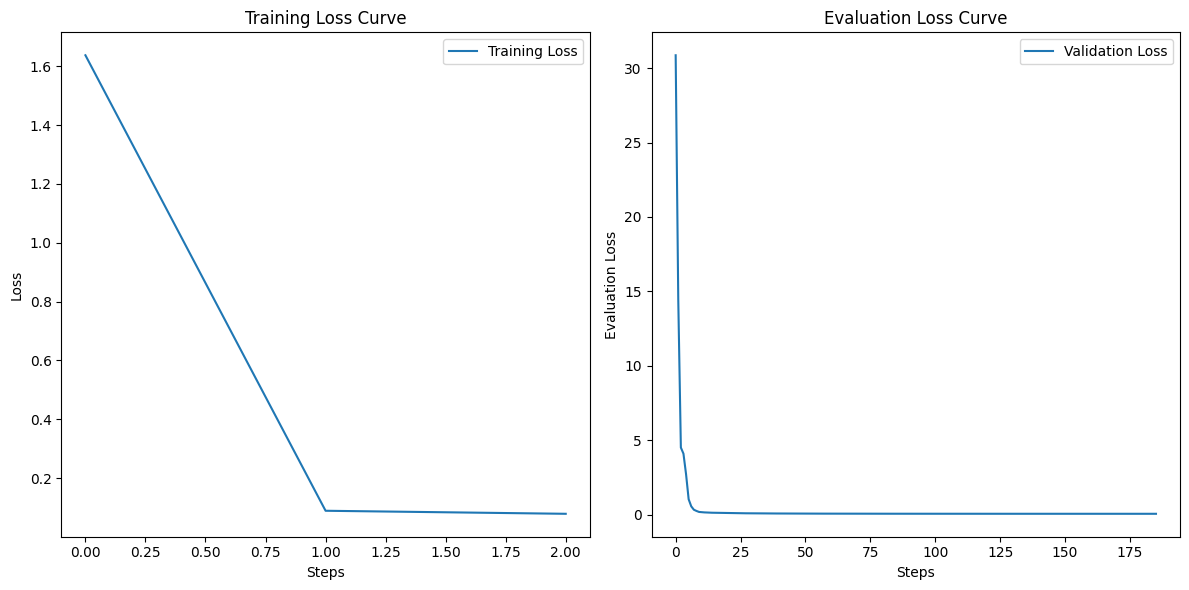

In [26]:
# Path to the log file
log_file_path = f"{output_dir}/checkpoint-1865/trainer_state.json"

# Load the log file
with open(log_file_path, "r") as log_file:
    logs = json.load(log_file)

# Extract the training loss
training_loss = [entry["loss"] for entry in logs["log_history"] if "loss" in entry]
# Extract the validation loss 
validation_loss = [entry['eval_loss'] for entry in logs["log_history"] if "eval_loss" in entry]

# Plot the learning curve
plt.figure(figsize = (10, 6))
plt.plot(training_loss, 'bo-', label = "Training loss")
plt.plot(validation_loss, 'ro-', label = "Validation loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.xlim([-5, 120]) 
plt.legend()
plt.savefig('Learning_Curve_Chatbot')
plt.show()

#### Save the fine-tuned model

In [27]:
peft_model_path="./peft-conversation-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-conversation-checkpoint-local\\tokenizer_config.json',
 './peft-conversation-checkpoint-local\\special_tokens_map.json',
 './peft-conversation-checkpoint-local\\tokenizer.json')

#### Define the final model

In [28]:
peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype = torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Add the trained adapter to the original Flan-T5-Base model
peft_model = PeftModel.from_pretrained(peft_model_base,
                                       'peft-conversation-checkpoint-local',
                                       torch_dtype = torch.bfloat16,
                                       is_trainable = False)

## Evaluate the final model performance

Textual responses were generated as suggested by Bhandare (n.d.).

References: 
Bhandare, A. (n.d.). Fine-tune Flan-T5-base for chat with PEFT/LoRA! Kaggle. https://www.kaggle.com/code/ajinkyabhandare2002/fine-tune-flan-t5-base-for-chat-with-peft-lora

In [30]:
def insert_prompt(prompt):
    
    input_ids = tokenizer(prompt, return_tensors = "pt").input_ids # get the input_ids from the received prompt
    outputs = peft_model.generate(input_ids = input_ids, generation_config = GenerationConfig(max_new_tokens = 200, num_beams = 1)) # get the model outputs
    text_output = tokenizer.decode(outputs[0], skip_special_tokens = True) # convert the model outputs into text

    return text_output

In [31]:
prompt = "Hello, how are you?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
where is paris?
PEFT MODEL: France


In [32]:
prompt = "What is your name?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the capital of california?
PEFT MODEL: San Francisco


In [33]:
prompt = "Are you happy today?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the capital of Italy
PEFT MODEL: Rome


In [35]:
prompt = "What is your favorite color?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the best drink for a hangover?
PEFT MODEL: a stout


In [ ]:
prompt = "What is your dream?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [36]:
prompt = "Do you think it will rain in the afternoon?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

question:
What is the probability that two apples will fall at the same time?
PEFT MODEL: 1 / 2


In [ ]:
prompt = "What is the capital of California?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "What is the capital of Italy?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "When does summer begin?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "What is the best drink for a hangover?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "What is the probability that two apples will fall at the same time?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "Could you please recommend an American dish?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "Where would you go on vacation this summer?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "What is Buddhism?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "Could you suggest a person's name with C?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "Who is Chris Martin?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "When will next Easter be celebrated?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "What is rosemary?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')

In [ ]:
prompt = "What would you do in case of dehydration?"

print(f'question:\n{prompt}')
print(f'PEFT MODEL: {insert_prompt(prompt)}')